In [42]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor, GradientBoostingRegressor

import optuna

# Reading data

In [43]:
data = pd.read_csv("housing.csv")

In [44]:
target = data.loc[:,"median_house_value"].copy()
target

0        452600
1        358500
2        352100
3        341300
4        342200
          ...  
20635     78100
20636     77100
20637     92300
20638     84700
20639     89400
Name: median_house_value, Length: 20640, dtype: int64

In [45]:
data1 = data.copy()

In [46]:
data1 = data1.drop(["median_house_value"],axis=1)

In [47]:
data1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND


In [48]:
data1.select_dtypes("object")

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
...,...
20635,INLAND
20636,INLAND
20637,INLAND
20638,INLAND


In [49]:
data1.select_dtypes(np.number)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41,880,129.0,322,126,8.3252
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014
2,-122.24,37.85,52,1467,190.0,496,177,7.2574
3,-122.25,37.85,52,1274,235.0,558,219,5.6431
4,-122.25,37.85,52,1627,280.0,565,259,3.8462
...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603
20636,-121.21,39.49,18,697,150.0,356,114,2.5568
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672


In [50]:
data1.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [51]:
data2 = data1.copy()

# Missing values

### KNN model for missing values (Quantitative Data)

In [52]:
def knn_missing(dataset,target_col):

    number_df = dataset.select_dtypes(np.number)
    
    y_train = number_df.loc[number_df[target_col].isna() == False,target_col] #targeted column with no missing values

    X_train0 = number_df.loc[number_df[target_col].isna() == False,:]
    X_train = X_train0.drop([target_col],axis =1)
    
    X_test0 = number_df.loc[number_df[target_col].isna() == True,:]
    X_test = X_test0.drop([target_col],axis=1)

    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    dataset.loc[dataset[target_col].isna() == True, target_col] = y_pred

    return dataset

In [53]:
knn_missing(data2,"total_bedrooms")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,374.0,845,330,1.5603,INLAND
20636,-121.21,39.49,18,697,150.0,356,114,2.5568,INLAND
20637,-121.22,39.43,17,2254,485.0,1007,433,1.7000,INLAND
20638,-121.32,39.43,18,1860,409.0,741,349,1.8672,INLAND


In [54]:
data2.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
dtype: int64

# Feature Transformation

### Skew feature transformation

In [55]:
data3 = data2.copy()

In [56]:
skew_df = pd.DataFrame(data3.select_dtypes(np.number).columns, columns=["Features"])
skew_df["Skew"] = skew_df["Features"].apply(lambda x: scipy.stats.skew(data3[x]))
skew_df["Abs_skew"] = skew_df["Skew"].apply(abs)
skew_df["Skewed"] = skew_df["Abs_skew"].apply(lambda x: True if x>0.5 else False)
skew_df

,Features,Skew,Abs_skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,4.147042,4.147042,True
4,total_bedrooms,3.450150,3.450150,True
5,population,4.935500,4.935500,True
6,households,3.410190,3.410190,True
7,median_income,1.646537,1.646537,True


In [57]:
for column in skew_df.query("Skewed == True")["Features"].values:
    data3[column] = np.log1p(data3[column])

In [58]:
skew_df = pd.DataFrame(data3.select_dtypes(np.number).columns, columns=["Features"])
skew_df["Skew"] = skew_df["Features"].apply(lambda x: scipy.stats.skew(data3[x]))
skew_df["Abs_skew"] = skew_df["Skew"].apply(abs)
skew_df["Skewed"] = skew_df["Abs_skew"].apply(lambda x: True if x>0.5 else False)
skew_df

,Features,Skew,Abs_skew,Skewed
0,longitude,-0.297780,0.297780,False
1,latitude,0.465919,0.465919,False
2,housing_median_age,0.060326,0.060326,False
3,total_rooms,-1.075455,1.075455,True
4,total_bedrooms,-0.987519,0.987519,True
5,population,-1.044011,1.044011,True
6,households,-1.051531,1.051531,True
7,median_income,0.226067,0.226067,False


In [59]:
data3

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41,6.781058,4.867534,5.777652,4.844187,2.232720,NEAR BAY
1,-122.22,37.86,21,8.867850,7.009409,7.784057,7.037906,2.230165,NEAR BAY
2,-122.24,37.85,52,7.291656,5.252273,6.208590,5.181784,2.111110,NEAR BAY
3,-122.25,37.85,52,7.150701,5.463832,6.326149,5.393628,1.893579,NEAR BAY
4,-122.25,37.85,52,7.395108,5.638355,6.338594,5.560682,1.578195,NEAR BAY
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,7.418181,5.926926,6.740519,5.802118,0.940124,INLAND
20636,-121.21,39.49,18,6.548219,5.017280,5.877736,4.744932,1.268861,INLAND
20637,-121.22,39.43,17,7.720905,6.186209,6.915723,6.073045,0.993252,INLAND
20638,-121.32,39.43,18,7.528869,6.016157,6.609349,5.857933,1.053336,INLAND


# Encoding Categorical Data

In [60]:
data4 = data3.copy()

In [61]:
data4 = pd.get_dummies(data4)

In [62]:
data4

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41,6.781058,4.867534,5.777652,4.844187,2.232720,0,0,0,1,0
1,-122.22,37.86,21,8.867850,7.009409,7.784057,7.037906,2.230165,0,0,0,1,0
2,-122.24,37.85,52,7.291656,5.252273,6.208590,5.181784,2.111110,0,0,0,1,0
3,-122.25,37.85,52,7.150701,5.463832,6.326149,5.393628,1.893579,0,0,0,1,0
4,-122.25,37.85,52,7.395108,5.638355,6.338594,5.560682,1.578195,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,7.418181,5.926926,6.740519,5.802118,0.940124,0,1,0,0,0
20636,-121.21,39.49,18,6.548219,5.017280,5.877736,4.744932,1.268861,0,1,0,0,0
20637,-121.22,39.43,17,7.720905,6.186209,6.915723,6.073045,0.993252,0,1,0,0,0
20638,-121.32,39.43,18,7.528869,6.016157,6.609349,5.857933,1.053336,0,1,0,0,0


# Scaler transformation

In [63]:
scaler = StandardScaler()
scaler.fit(data4)

data4 = pd.DataFrame(scaler.transform(data4), index=data4.index, columns=data4.columns)

In [64]:
data4

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-1.131133,-1.634229,-1.694943,-1.569395,1.995505,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
1,-1.322844,1.043185,-0.607019,1.651357,1.314159,1.030337,1.449251,1.988380,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2,-1.332827,1.038503,1.856182,-0.450310,-1.104618,-1.109604,-1.104849,1.656444,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
3,-1.337818,1.038503,1.856182,-0.638257,-0.813399,-0.949925,-0.813343,1.049948,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
4,-1.337818,1.038503,1.856182,-0.312370,-0.573160,-0.933021,-0.583469,0.170631,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.281605,-0.175928,-0.387090,-0.251243,-1.608366,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20636,-0.818722,1.806329,-0.845393,-1.441596,-1.428098,-1.559000,-1.705974,-0.691819,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20637,-0.823713,1.778237,-0.924851,0.122042,0.180986,-0.149112,0.121563,-1.460242,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20638,-0.873626,1.778237,-0.845393,-0.134015,-0.053097,-0.565257,-0.174439,-1.292722,-0.891156,1.466514,-0.015566,-0.353264,-0.384466


# Target transformation

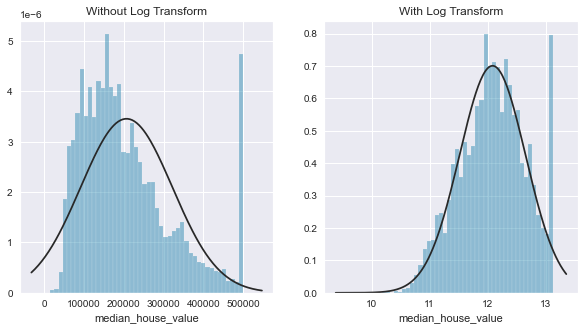

In [65]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=False, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=False, fit=scipy.stats.norm)
plt.title("With Log Transform")

plt.show()

In [66]:
target_log = np.log(target)

In [67]:
target_log

0        13.022764
1        12.789684
2        12.771671
3        12.740517
4        12.743151
           ...    
20635    11.265745
20636    11.252859
20637    11.432799
20638    11.346871
20639    11.400876
Name: median_house_value, Length: 20640, dtype: float64

# Spliting Data

In [68]:
data5 = data4.copy()

In [69]:
data5 = pd.concat([target_log,data4],axis=1)
data5

,median_house_value,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,13.022764,-1.327835,1.052548,0.982143,-1.131133,-1.634229,-1.694943,-1.569395,1.995505,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
1,12.789684,-1.322844,1.043185,-0.607019,1.651357,1.314159,1.030337,1.449251,1.988380,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2,12.771671,-1.332827,1.038503,1.856182,-0.450310,-1.104618,-1.109604,-1.104849,1.656444,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
3,12.740517,-1.337818,1.038503,1.856182,-0.638257,-0.813399,-0.949925,-0.813343,1.049948,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
4,12.743151,-1.337818,1.038503,1.856182,-0.312370,-0.573160,-0.933021,-0.583469,0.170631,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,11.265745,-0.758826,1.801647,-0.289187,-0.281605,-0.175928,-0.387090,-0.251243,-1.608366,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20636,11.252859,-0.818722,1.806329,-0.845393,-1.441596,-1.428098,-1.559000,-1.705974,-0.691819,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20637,11.432799,-0.823713,1.778237,-0.924851,0.122042,0.180986,-0.149112,0.121563,-1.460242,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20638,11.346871,-0.873626,1.778237,-0.845393,-0.134015,-0.053097,-0.565257,-0.174439,-1.292722,-0.891156,1.466514,-0.015566,-0.353264,-0.384466


In [72]:
data5 = data5.drop(["median_house_value"],axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(data5, target_log, test_size = 0.2)

In [74]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
16036,-1.442635,0.977638,1.538349,-0.261745,-0.310803,-0.211145,-0.306377,-0.170885,-0.891156,-0.681889,-0.015566,-0.353264,2.601007
3185,-0.109956,0.312814,-1.004309,-0.240623,-0.587935,-0.297022,-0.433207,0.443144,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
12431,1.696897,-0.984063,-1.242684,-0.243731,0.255412,0.767223,0.149806,-1.049374,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
5270,0.508966,-0.749970,0.505394,1.978754,2.027740,1.597563,2.020413,1.208054,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
12696,-0.923539,1.389643,0.505394,-0.756274,-1.083165,-0.911593,-1.007852,-0.947443,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13348,0.963175,-0.749970,-1.481058,0.586642,0.424386,0.840698,0.447511,0.355215,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
15334,1.122897,-1.129201,-1.004309,-0.887020,-0.831009,-1.720412,-0.800890,-0.550522,-0.891156,-0.681889,-0.015566,-0.353264,2.601007
4797,0.608792,-0.754652,1.856182,-2.093747,-2.095283,-2.132762,-1.682248,-0.195378,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
8264,0.693644,-0.871699,0.664310,0.339274,0.787367,-0.045375,0.777392,-0.856914,-0.891156,-0.681889,-0.015566,-0.353264,2.601007


In [75]:
y_train

16036    12.308178
3185     11.441429
12431    10.978490
5270     13.122365
12696    11.540541
           ...    
13348    11.977288
15334    11.426278
4797     11.810805
8264     12.691580
10493    12.572450
Name: median_house_value, Length: 16512, dtype: float64

In [76]:
X_test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
4371,0.643731,-0.712515,1.856182,-0.175493,0.037840,-0.483557,-0.029066,0.562784,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
4295,0.638740,-0.721879,0.028646,0.113738,0.854963,0.944559,0.855826,-0.874100,1.122138,-0.681889,-0.015566,-0.353264,-0.384466
15878,-1.417679,0.991684,1.856182,-0.271241,-0.132569,0.111275,-0.143341,-0.672991,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
13985,1.142862,-0.445649,-0.050812,-0.083401,-0.013387,0.038145,0.026399,-1.265049,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
16138,-1.442635,1.005730,1.856182,0.932455,1.153424,0.802452,1.114434,-0.083758,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16278,-0.848670,1.075958,-0.368645,-0.464923,-0.389960,0.310607,-0.461975,-1.052673,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
12777,-0.923539,1.408370,1.061601,-0.238297,-0.146871,-0.068035,-0.124256,-1.298660,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
16055,-1.457609,0.996366,1.856182,-0.529841,-0.842876,-0.627051,-0.481494,1.118967,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2364,-0.010130,0.509452,-0.845393,-0.627840,-1.083165,-0.804872,-1.007852,0.542417,-0.891156,1.466514,-0.015566,-0.353264,-0.384466


In [77]:
y_test

4371     12.795247
4295     12.058153
15878    12.450195
13985    10.925938
16138    12.839470
           ...    
16278    11.021902
12777    11.010399
16055    12.736112
2364     11.779894
18507    12.511349
Name: median_house_value, Length: 4128, dtype: float64

# Comparing models

In [ ]:
# _ = setup(data5, target='median_house_value')

In [ ]:
# compare_models()

# Training Model

In [78]:
models = {
    "catboost": CatBoostRegressor(verbose = 0),
    "lightgbm": LGBMRegressor(),
    "randomforest": RandomForestRegressor(),
    "Extree": ExtraTreesRegressor(),
    "Gbr":GradientBoostingRegressor()
}

In [79]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

catboost trained.
lightgbm trained.
randomforest trained.
Extree trained.
Gbr trained.


# Evaluation

In [81]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

KeyboardInterrupt: 

In [ ]:
for name, result in results.items():
    print("****************\n" + name)
    print(np.mean(result))
    print(np.std(result))

****************
catboost
1.0175244579740492
0.008677515825058942
****************
lightgbm
1.0170517850849676
0.008367241586010547
****************
randomforest
1.0020392157246163
0.001697776065293418
****************
Extree
1.0023596316248506
0.002130150461826099
****************
Gbr
1.004894893164205
0.00010841837673669373


# Predictions

In [82]:
final_predictions = (
    0.4 * np.exp(models['catboost'].predict(X_test)) +
    0.2 * np.exp(models['lightgbm'].predict(X_test)) +
    0.2 * np.exp(models['randomforest'].predict(X_test)) +
    0.1 * np.exp(models['Extree'].predict(X_test)) +
    0.1 * np.exp(models['Gbr'].predict(X_test))
)

In [83]:
final_predictions

array([343840.65490552, 219354.03826907, 221753.03908897, ...,
       404812.6222664 , 125091.21410486, 370453.37522936])

# Final Submit

In [84]:
final = pd.DataFrame()
final["House ID"] = X_test.index
final["pred"] = final_predictions
final

,House ID,pred
0,4371,343840.654906
1,4295,219354.038269
2,15878,221753.039089
3,13985,68900.431840
4,16138,398493.028342
...,...,...
4123,16278,72050.087600
4124,12777,70393.252887
4125,16055,404812.622266
4126,2364,125091.214105


In [85]:
data4

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.327835,1.052548,0.982143,-1.131133,-1.634229,-1.694943,-1.569395,1.995505,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
1,-1.322844,1.043185,-0.607019,1.651357,1.314159,1.030337,1.449251,1.988380,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
2,-1.332827,1.038503,1.856182,-0.450310,-1.104618,-1.109604,-1.104849,1.656444,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
3,-1.337818,1.038503,1.856182,-0.638257,-0.813399,-0.949925,-0.813343,1.049948,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
4,-1.337818,1.038503,1.856182,-0.312370,-0.573160,-0.933021,-0.583469,0.170631,-0.891156,-0.681889,-0.015566,2.830742,-0.384466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.281605,-0.175928,-0.387090,-0.251243,-1.608366,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20636,-0.818722,1.806329,-0.845393,-1.441596,-1.428098,-1.559000,-1.705974,-0.691819,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20637,-0.823713,1.778237,-0.924851,0.122042,0.180986,-0.149112,0.121563,-1.460242,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
20638,-0.873626,1.778237,-0.845393,-0.134015,-0.053097,-0.565257,-0.174439,-1.292722,-0.891156,1.466514,-0.015566,-0.353264,-0.384466
